# BioImageIO Crowd Sourcing Demo

This notebook runs a BioEngine server equipped with Kaibu, an interactive image annotation tool in the browser.

It allows the annotation of images in a collaborative manner.

As a demo, we will collect image annotations from the participants and train a CellPose model using dose.

In [16]:
## Install required dependencies

!git clone https://github.com/bioimage-io/bioimageio-colab.git
!pip install -r "/content/bioimageio-colab/requirements-colab.txt"

!pip install numpy==1.26.4
!pip install imjoy-rpc==0.5.48.post2
!pip install requests==2.31.0
!pip install kaibu-utils==0.1.14
!pip install tifffile
!pip install matplotlib
!pip install imjoy-jupyterlab-extension
!pip install kaibu-utils
!pip install "opencv-python-headless<4.3"
!pip install cellpose

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 MB 16.6 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.9.0.80
    Uninstalling opencv-python-headless-4.9.0.80:
      Successfully uninstalled opencv-python-headless-4.9.0.80
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 1.3.1 requires opencv-python-headless>=4.1.1, but you have opencv-python-headless 3.4.18.65 which is incompatible.
qudida 0.0.4 requires opencv-python-headless>=4.0.1, but you have opencv-python-headless 3.4.18.65 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 205.0/205.0 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.6/39.6 MB 13.1 MB/s eta 0:00:00
  Using cached nvidia_cud

In [5]:
# Mount google colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import os
from imjoy_rpc.hypha import connect_to_server
import numpy as np
# Prepare paths for output
from tifffile import imread, imwrite
from kaibu_utils import fetch_image, features_to_mask

url = "https://github.com/bioimage-io/bioimageio-colab/releases/download/v0.1/hpa-dataset-v2-98-rgb.zip"
#!wget "https://github.com/bioimage-io/bioimageio-colab/releases/download/v0.1/hpa-dataset-v2-98-rgb.zip"
#!mkdir "data"
#!unzip hpa-dataset-v2-98-rgb.zip -d data/

path2data = "/content/data"
outpath = "/content/drive/MyDrive/HENRIQUES LAB/PROJECTS/BIOIMAGE MODEL ZOO/kaibu_annotations"
os.makedirs(outpath, exist_ok=True)

training_images = []
async def start_server(server_url,path2data, outpath):

    path2label = os.path.join(outpath, "labels")
    os.makedirs(path2label, exist_ok=True)

    path2source = os.path.join(outpath, "source")
    os.makedirs(path2source, exist_ok=True)
    # Connect to the server link
    server = await connect_to_server({"server_url": server_url})
    # When multiple people open the link above, they can join a common workspace as an ImJoy client
    def add_image(image, label):
        training_images.append((image, label))
        print(f"{len(training_images)} available already.")
        return

    def get_random_image():
        filenames = [f for f in os.listdir(path2data) if f.endswith(".tif")]
        n = np.random.randint(len(filenames)-1)
        image = imread(os.path.join(path2data, filenames[n]))
        if len(image.shape)==3 and image.shape[0]==3:
            image = np.transpose(image, [1,2,0])
        #print(image.shape)
        new_filename = f"{len(os.listdir(path2source)) + 1}_{filenames[n]}"


        return image, filenames[n], new_filename,

    def save_annotation(filename, newname, features, image_shape):
        mask = features_to_mask(features, image_shape)
        image = imread(os.path.join(path2data, filename))
        if len(image.shape)==3 and image.shape[0]==3:
            image = np.transpose(image, [1,2,0])
        imwrite(os.path.join(path2source, newname), image)
        imwrite(os.path.join(path2label, newname), mask)


    await server.register_service({
        "name": "Model Trainer",
        "id": "biocolab",
        "config": {
            "visibility": "public"
        },
        "get_random_image": get_random_image,
        "save_annotation": save_annotation,

    })

    print("https://imjoy.io/lite?plugin=https://raw.githubusercontent.com/bioimage-io/bioimageio-colab/main/plugins/bioimageio-colab.imjoy.html")


server_url = "https://ai.imjoy.io"
await start_server(server_url, path2data, outpath)

https://imjoy.io/lite?plugin=https://raw.githubusercontent.com/bioimage-io/bioimageio-colab/main/plugins/bioimageio-colab.imjoy.html


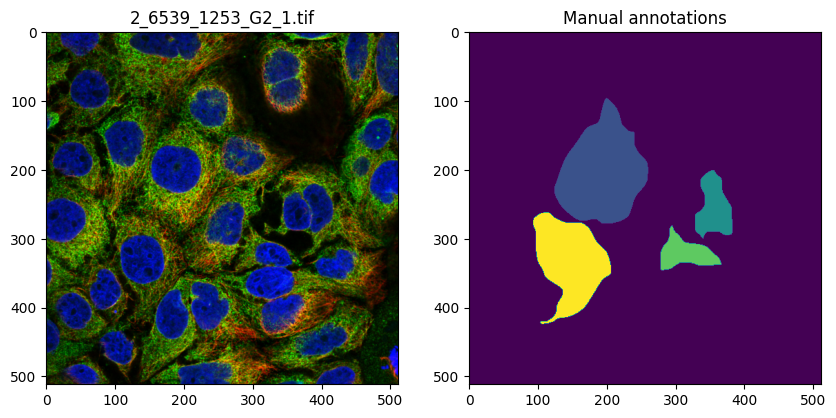

In [15]:
import matplotlib.pyplot as plt

path2label = os.path.join(outpath, "labels")
path2source = os.path.join(outpath, "source")
annotations = [f for f in os.listdir(path2source) if f.endswith(".tif")]
k=1

plt.figure(figsize=(10,20))
plt.subplot(1,2,1)
plt.imshow(imread(os.path.join(path2source, annotations[k])))
plt.title(f"{annotations[k]}")
plt.subplot(1,2,2)
plt.imshow(imread(os.path.join(path2label, annotations[k])))
plt.title(f"Manual annotations")
plt.show()


In [17]:
!nvcc --version
!nvidia-smi

import os, shutil
import numpy as np
import matplotlib.pyplot as plt
from cellpose import core, utils, io, models, metrics
from glob import glob

use_GPU = core.use_gpu()
yn = ['NO', 'YES']
print(f'>>> GPU activated? {yn[use_GPU]}')

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
/bin/bash: line 1: nvidia-smi: command not found
>>> GPU activated? NO
